In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


class AnnotatedLineChart:
    """
    AnnotatedLineChart
    Created by: Washington Alto using ChatGPT 4o
    Date created: September 2025
    Copyright 2025, Washington Alto. All rights reserved
    ==================
    A helper class for creating clean, annotated line charts in Matplotlib with:
      - Multiple series support
      - Automatic end-of-line label placement (avoiding overlap)
      - Flexible annotation system with offsets in data or pixel units
      - Optional export to PNG, JPG, PDF, or SVG
      - Excel-awareness (works with pandas DataFrames, including datetime axes)

    Parameters
    ----------
    df : pandas.DataFrame
        Input data. Must contain one column for the x-axis and one or more y-axis series.
    x_col : str
        Column name to use as the x-axis.
        Can be numeric or datetime (datetime is automatically detected and formatted).
    y_cols : list of str
        List of one or more column names to plot as y-series.

    Attributes
    ----------
    df : pandas.DataFrame
        Internal copy of the data.
    x_col, y_cols : str, list
        Axis/series definitions.
    annotations : dict
        Holds user-specified annotations per series.
    colors : dict
        Custom color mapping for series.
    _border_visible : bool
        Whether to show the top/right chart borders.
    fig, ax : matplotlib Figure, Axes
        The underlying Matplotlib objects.

    Usage Example
    -------------
    >>> df = pd.DataFrame({
    ...     "Date": pd.date_range("2025-01-01", "2025-01-10"),
    ...     "Series A": range(10),
    ...     "Series B": range(10, 20)
    ... })
    >>> chart = AnnotatedLineChart(df, x_col="Date", y_cols=["Series A","Series B"])
    >>> chart.set_labels(x_label="Date", y_label="Value", title="Demo Chart")
    >>> chart.set_colors({"Series A":"red","Series B":"blue"})
    >>> chart.add_annotations({
    ...     "Series A": {
    ...         pd.Timestamp("2025-01-05"): {"text": "Key Point", "offset": (2, 3)}
    ...     }
    ... })
    >>> chart.set_border(False)
    >>> chart.plot()
    >>> chart.export("demo_chart", format="png")

    Methods
    -------
    set_labels(x_label=None, y_label=None, title=None)
        Set axis labels and chart title.
    set_colors(color_map)
        Provide custom colors for each series.
    add_annotations(annotations)
        Add annotations to one or more series (see details below).
    set_border(visible=True)
        Show or hide top/right borders of the chart.
    plot()
        Render the chart with annotations and automatic label placement.
    export(filename, format="png", dpi=300)
        Save the chart to file in PNG, JPG, PDF, or SVG format.

    Annotation System
    -----------------
    The `add_annotations` method accepts a dictionary of the form:

    >>> {
    ...   "SeriesName": {
    ...       x_value: {"text": "Annotation label",
    ...                 "offset": (dx, dy),
    ...                 "offset_units": "data" or "points"}
    ...   }
    ... }

    Where:
      - **SeriesName**: must match one of the y_cols.
      - **x_value**: must exist in the DataFrame’s x_col (datetime or numeric).
      - **text**: annotation label string.
      - **offset**: tuple (dx, dy) controlling where the text is placed relative to the point.
      - **offset_units**:
          * `"data"` (default): dx/dy are interpreted in *data coordinates*.
              - If x-axis is numeric: dx is a numeric offset in the same units as the x-axis.
              - If x-axis is datetime:
                  + dx as int/float → interpreted as *days*
                  + dx as pd.Timedelta / datetime.timedelta → applied directly
                  + dx as str → parsed with `pd.to_timedelta` (e.g., "2h", "3d")
              - dy is always in y-axis data units.
              Example: `offset=(2, -5)` means *2 days right, 5 units down* for a datetime axis.
          * `"points"`: dx/dy are offsets in *screen points* (pixels on the figure).
              - Useful when you want precise placement unaffected by axis scaling.
              Example: `offset=(20, -10), offset_units="points"` → 20 pixels right, 10 pixels down.

    Notes
    -----
    - When multiple series are plotted, labels at line ends are automatically staggered
      to avoid overlap.
    - Border control lets you hide the top and right spines for a cleaner style.
    - The class is Excel-friendly since you can feed it directly with DataFrames
      loaded from `.xlsx` via `pandas.read_excel`.
    """

    def __init__(self, df, x_col, y_cols):
        self.df = df.copy()
        self.x_col = x_col
        self.y_cols = y_cols
        self.title = None
        self.x_label = x_col
        self.y_label = "Value"
        self.colors = {}
        self.annotations = {}
        self.fig, self.ax = plt.subplots()
        self._border_visible = True

    def set_labels(self, x_label=None, y_label=None, title=None):
        """Set chart labels and title."""
        if x_label:
            self.x_label = x_label
        if y_label:
            self.y_label = y_label
        if title:
            self.title = title

    def set_colors(self, color_map):
        """Set custom colors for series. Example: {'Series A':'red'}"""
        self.colors = color_map

    def add_annotations(self, annotations):
        """
        Add annotations to chart.

        Parameters
        ----------
        annotations : dict
            Dictionary of the form:
            {
                "SeriesName": {
                    x_value: {"text": str, "offset": (dx, dy), "offset_units": "data"|"points"}
                }
            }
        """
        self.annotations.update(annotations)

    def set_border(self, visible=True):
        """Toggle visibility of top/right chart border lines (spines)."""
        self._border_visible = visible

    def _apply_axis_limits(self):
        """Apply dynamic axis limits based on data values."""
        x_min, x_max = self.df[self.x_col].min(), self.df[self.x_col].max()
        y_min, y_max = self.df[self.y_cols].min().min(), self.df[self.y_cols].max().max()

        if pd.api.types.is_datetime64_any_dtype(self.df[self.x_col]):
            extra = (x_max - x_min) * 0.3
            self.ax.set_xlim(x_min, x_max + extra)
        else:
            self.ax.set_xlim(x_min, x_max + (x_max - x_min) * 0.3)

        if y_min >= 0:
            self.ax.set_ylim(0, y_max * 1.1)
        else:
            self.ax.set_ylim(y_min * 1.1, y_max * 1.1)

    def _format_x_axis(self):
        """Detect and format x-axis for datetime or numeric properly."""
        if pd.api.types.is_datetime64_any_dtype(self.df[self.x_col]):
            x_range = self.df[self.x_col].max() - self.df[self.x_col].min()
            if x_range.days > 365 * 2:  # multiple years
                self.ax.xaxis.set_major_locator(mdates.YearLocator())
                self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            elif x_range.days > 60:  # months range
                self.ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
                self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
            else:  # short range, show days
                self.ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
                self.ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            self.fig.autofmt_xdate()
        else:
            if pd.api.types.is_integer_dtype(self.df[self.x_col]):
                self.ax.xaxis.get_major_locator().set_params(integer=True)

    def plot(self):
        """Render the chart with lines, labels, and annotations."""
        series_colors = {}
        endpoints = []

        for col in self.y_cols:
            color = self.colors.get(col, None)
            line, = self.ax.plot(self.df[self.x_col], self.df[col], label=col, color=color)
            series_colors[col] = line.get_color()
            x = self.df[self.x_col].iloc[-1]
            y = self.df[col].iloc[-1]
            endpoints.append([x, y, col, line.get_color()])

        endpoints.sort(key=lambda e: e[1], reverse=True)
        min_gap = (self.df[self.y_cols].max().max() - self.df[self.y_cols].min().min()) * 0.03
        adjusted_y = []

        for x, y, label, color in endpoints:
            if adjusted_y and y > adjusted_y[-1] - min_gap:
                y = adjusted_y[-1] - min_gap
            adjusted_y.append(y)

            dx = (self.df[self.x_col].max() - self.df[self.x_col].min())
            dx = dx * 0.02 if not isinstance(dx, int) else 0.2
            self.ax.text(
                x + dx, y,
                label,
                va="center",
                color=color,
                fontsize=9,
                fontweight="bold"
            )

        for series, annots in self.annotations.items():
            for x_val, meta in annots.items():
                if x_val not in self.df[self.x_col].values:
                    continue
                y_val = self.df.loc[self.df[self.x_col] == x_val, series].values[0]
                dx, dy = meta.get("offset", (0.3, 5))
                offset_units = meta.get("offset_units", "data")

                if offset_units == "data":
                    if isinstance(x_val, (pd.Timestamp, datetime.date, datetime.datetime)):
                        if isinstance(dx, (int, float)):
                            x_text = x_val + pd.Timedelta(days=dx)
                        elif isinstance(dx, str):
                            x_text = x_val + pd.to_timedelta(dx)
                        else:
                            x_text = x_val + dx
                    else:
                        x_text = x_val + dx
                    y_text = y_val + dy
                elif offset_units == "points":
                    x_text, y_text = 0, 0
                else:
                    raise ValueError("offset_units must be 'data' or 'points'")

                self.ax.annotate(
                    meta["text"],
                    (x_val, y_val),
                    xytext=(x_text, y_text) if offset_units == "data" else (dx, dy),
                    textcoords="data" if offset_units == "data" else "offset points",
                    arrowprops=dict(arrowstyle="->", color=series_colors[series]),
                    fontsize=8,
                    color=series_colors[series]
                )

        self._apply_axis_limits()
        self._format_x_axis()
        self.ax.margins(x=0.15)
        self.ax.set_xlabel(self.x_label)
        self.ax.set_ylabel(self.y_label)
        if self.title:
            self.ax.set_title(self.title)

        if not self._border_visible:
            self.ax.spines["top"].set_visible(False)
            self.ax.spines["right"].set_visible(False)

        self.fig.tight_layout()
        plt.show()

    def export(self, filename, format="png", dpi=300):
        """Export the chart to a file (png, jpg, pdf, svg)."""
        self.fig.savefig(f"{filename}.{format}", format=format, dpi=dpi, bbox_inches="tight")


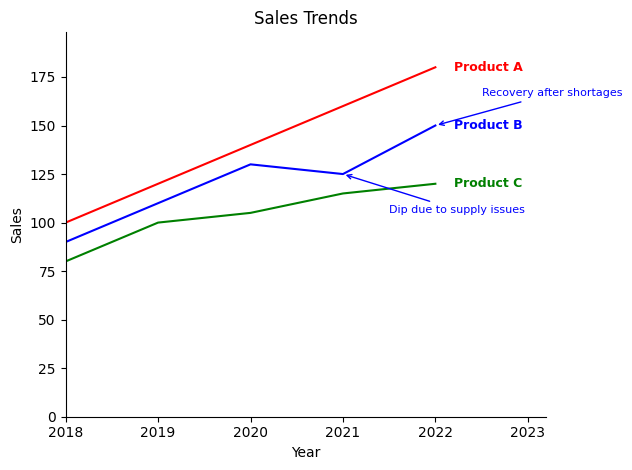

In [2]:
# Example DataFrame
data = {
    "Year": [2018, 2019, 2020, 2021, 2022],
    "Product A": [100, 120, 140, 160, 180],
    "Product B": [90, 110, 130, 125, 150],
    "Product C": [80, 100, 105, 115, 120],
}
df = pd.DataFrame(data)

# Create chart
chart = AnnotatedLineChart(df, x_col="Year", y_cols=["Product A", "Product B", "Product C"])
chart.set_labels(x_label="Year", y_label="Sales", title="Sales Trends")
chart.set_colors({"Product A": "red", "Product B": "blue", "Product C": "green"})
chart.add_annotations({
    "Product B": {
        2021: {"text": "Dip due to supply issues", "offset": (0.5, -20)},
        2022: {"text": "Recovery after shortages", "offset": (0.5, +15)}
    }
})

# Plot and export
chart.set_border(False)   # hides top & right spines
chart.plot()
chart.export("sales_trends", format="png")  # saves as sales_trends.png


In [3]:
import pandas as pd
import numpy as np

# Generate date range
dates = pd.date_range(start="2025-01-01", end="2025-02-15", freq="D")

# Simulated daily values
np.random.seed(42)  # reproducibility
product_a = np.linspace(100, 150, len(dates)) + np.random.normal(0, 2, len(dates))  # upward
product_b = np.linspace(80, 120, len(dates)) + np.random.normal(0, 5, len(dates))   # fluctuating
product_c = np.linspace(60, 70, len(dates)) + np.random.normal(0, 1, len(dates))    # stable

# Create DataFrame
df_daily = pd.DataFrame({
    "Date": dates,
    "Product A": product_a,
    "Product B": product_b,
    "Product C": product_c
})

print(df_daily.head())


        Date   Product A  Product B  Product C
0 2025-01-01  100.993428  77.696806  59.297947
1 2025-01-02  100.834583  86.174500  59.894560
2 2025-01-03  103.517599  83.495869  60.052336
3 2025-01-04  106.379393  73.851466  59.203152
4 2025-01-05  103.976138  85.175975  61.185009


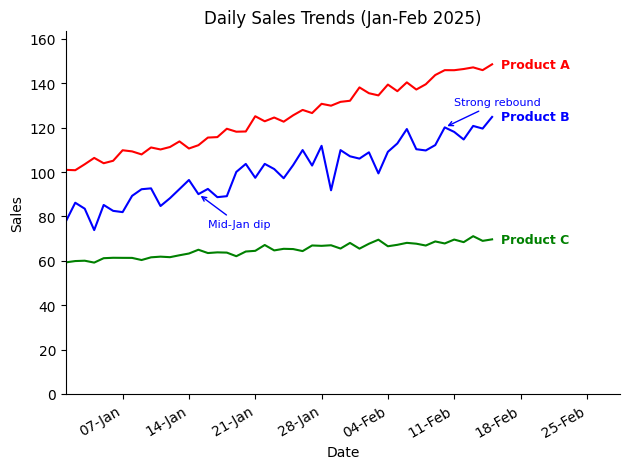

In [4]:
chart = AnnotatedLineChart(df_daily, x_col="Date", y_cols=["Product A", "Product B", "Product C"])
chart.set_labels(x_label="Date", y_label="Sales", title="Daily Sales Trends (Jan-Feb 2025)")
chart.set_colors({"Product A": "red", "Product B": "blue", "Product C": "green"})

# Add annotation to Product B dip & recovery
chart.add_annotations({
    "Product B": {
        pd.Timestamp("2025-01-15"): {"text": "Mid-Jan dip", "offset": (1, -15)},
        pd.Timestamp("2025-02-10"): {"text": "Strong rebound", "offset": (1, 10)}
    }
})

chart.set_border(False)   # Hide top/right borders
chart.plot()
